In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import os
import shutil
from tqdm import tqdm
import random
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

In [ ]:
import tarfile

tar_file_path = 'imports-impact.tar'

with tarfile.open(tar_file_path, 'r') as tar:
    tar.extractall(path='.')
    print("Extraction complete!")


Extraction complete!


In [ ]:
import pandas as pd

wmc_df = pd.read_csv("dataset/data/CC.csv")
imp_regular_df = pd.read_csv("dataset/data/IMP_REGULAR.csv")
imp_wildcard_df = pd.read_csv("dataset/data/IMP_WILDCARD.csv")
fanout_df = pd.read_csv("dataset/data/FANOUT.csv")

merged_df = wmc_df.merge(imp_regular_df, on=['repo', 'java_file'], how='inner')
merged_df = merged_df.merge(imp_wildcard_df, on=['repo', 'java_file'], how='inner')
merged_df = merged_df.merge(fanout_df, on=['repo', 'java_file'], how='inner')
merged_df.dropna(inplace=True)

print(merged_df.head())


                                                repo  \
0  react-native-component/react-native-smart-spla...   
1  react-native-component/react-native-smart-spla...   
2  react-native-component/react-native-smart-spla...   
3                          Ajian-studio/GAHonorClock   
4                          Ajian-studio/GAHonorClock   

                                           java_file    CC  IMP_REGULAR  \
0  /android/src/main/java/com/reactnativecomponen...   3.0          8.0   
1  /android/src/main/java/com/reactnativecomponen...  12.0          9.0   
2  /android/src/main/java/com/reactnativecomponen...  42.0         13.0   
3  /app/src/main/java/gastudio/clock/ClockByPathA...   3.0          3.0   
4  /app/src/main/java/gastudio/clock/MainActivity...   5.0          4.0   

   IMP_WILDCARD  FANOUT  
0           0.0     1.0  
1           0.0     5.0  
2           0.0    17.0  
3           0.0     2.0  
4           0.0     0.0  


##Dataset summary

### Amount of repositories in the dataset

In [ ]:
num_repos = len(merged_df['repo'].unique())
num_repos

### Amount of classes in the dataset

In [ ]:
num_repos = len(merged_df['java_file'].unique())
num_repos

59078

### Removing outliers

In [ ]:
filtered_df = merged_df[(merged_df['CC'] <= 300) & (merged_df['IMP_REGULAR'] < 100) & (merged_df['CC'] > 0)  & (merged_df['FANOUT'] < 100)]
filtered_df['Total_IMP'] = filtered_df['IMP_REGULAR'] + filtered_df['IMP_WILDCARD']


<ipython-input-10-76add92edc3d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Total_IMP'] = filtered_df['IMP_REGULAR'] + filtered_df['IMP_WILDCARD']


In [ ]:
num_filtered_repos = len(filtered_df['java_file'].unique())
num_filtered_repos

58443

### Dataset summary table

In [ ]:
metrics = ['CC', 'FANOUT', 'Total_IMP']

summary = (
    filtered_df[metrics]
      .describe()
      .loc[['min', '25%', '50%', '75%', 'max', 'mean']]
      .rename(index={
          '25%': 'Q1',
          '50%': 'median',
          '75%': 'Q3'
      })
)

print(summary)

\begin{tabular}{lrrr}
\toprule
 & CC & FANOUT & Total_IMP \\
\midrule
min & 1.00 & 0.00 & 0.00 \\
Q1 & 3.00 & 0.00 & 2.00 \\
median & 7.00 & 4.00 & 5.00 \\
Q3 & 19.00 & 12.00 & 11.00 \\
max & 297.00 & 99.00 & 88.00 \\
mean & 17.30 & 9.70 & 7.65 \\
\bottomrule
\end{tabular}

                CC     FANOUT  Total_IMP
min       1.000000   0.000000   0.000000
Q1        3.000000   0.000000   2.000000
median    7.000000   4.000000   5.000000
Q3       19.000000  12.000000  11.000000
max     297.000000  99.000000  88.000000
mean     17.296272   9.703379   7.648461


## Variable distribution

Spearman's ρ: 0.701, p = 0
Pearson's r:  0.722, p = 0
Kendall's τ:  0.549, p = 0
Kendall's τ imports :  0.339, p = 0


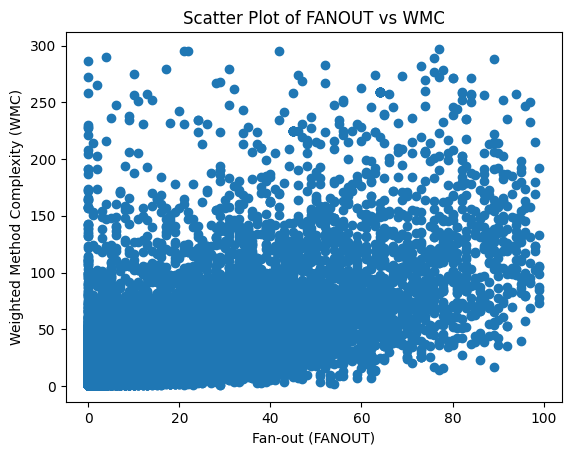

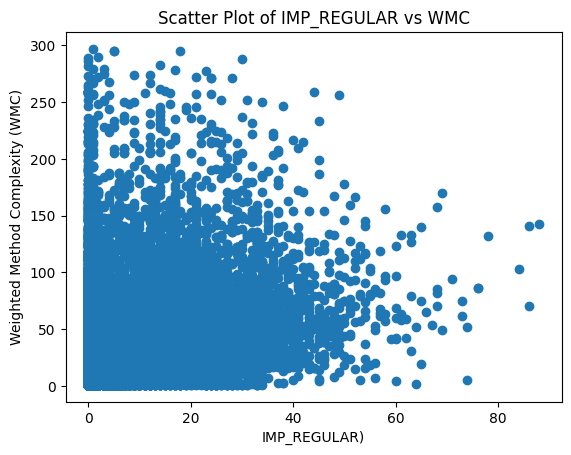

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr, kendalltau

rho, p_rho = spearmanr(filtered_df['FANOUT'], filtered_df['CC'])
r, p_r = pearsonr(filtered_df['FANOUT'], filtered_df['CC'])
tau, p_tau = kendalltau(filtered_df['FANOUT'], filtered_df['CC'])
h, heh = kendalltau(filtered_df['Total_IMP'], filtered_df['CC'])

print(f"Spearman's ρ: {rho:.3f}, p = {p_rho:.3g}")
print(f"Pearson's r:  {r:.3f}, p = {p_r:.3g}")
print(f"Kendall's τ:  {tau:.3f}, p = {p_tau:.3g}")
print(f"Kendall's τ imports :  {h:.3f}, p = {heh:.3g}")

# 2. Scatter plot of FANOUT vs WMC (CC)
fig, ax = plt.subplots()
ax.scatter(filtered_df['FANOUT'], filtered_df['CC'])
ax.set_xlabel('Fan‑out (FANOUT)')
ax.set_ylabel('Weighted Method Complexity (WMC)')
ax.set_title('Scatter Plot of FANOUT vs WMC')

fig, ax = plt.subplots()
ax.scatter(filtered_df['IMP_REGULAR'], filtered_df['CC'])
ax.set_xlabel('IMP_REGULAR)')
ax.set_ylabel('Weighted Method Complexity (WMC)')
ax.set_title('Scatter Plot of IMP_REGULAR vs WMC')
plt.show()

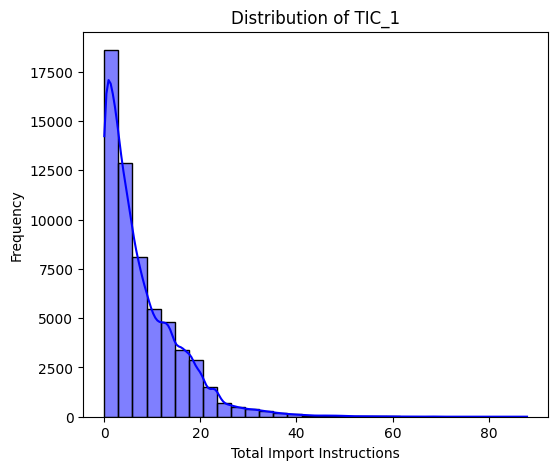

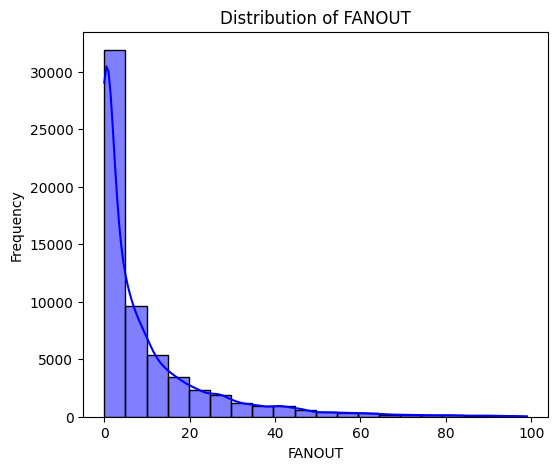

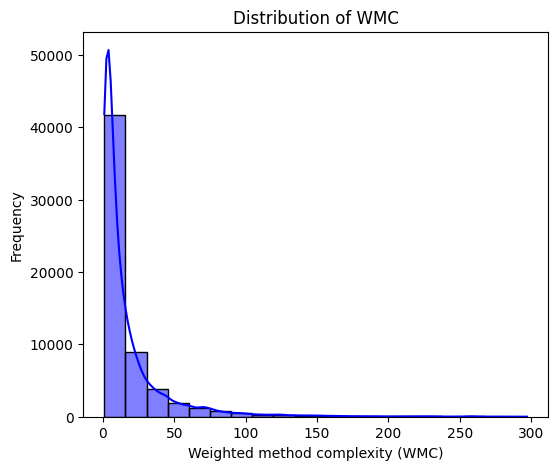

In [ ]:

plt.figure(figsize=(6, 5))
sns.histplot(filtered_df['Total_IMP'], bins=30, kde=True, color='blue')
plt.title("Distribution of TIC_1")
plt.xlabel("Total Import Instructions")
plt.ylabel("Frequency")

plt.figure(figsize=(6, 5))
sns.histplot(filtered_df['FANOUT'], bins=20, kde=True, color='blue')
plt.xlabel("FANOUT")
plt.ylabel("Frequency")
plt.title("Distribution of FANOUT")
plt.show()

plt.figure(figsize=(6, 5))
sns.histplot(filtered_df['CC'], bins=20, kde=True, color='blue')
plt.xlabel("Weighted method complexity (WMC)")
plt.ylabel("Frequency")
plt.title("Distribution of WMC")
plt.show()


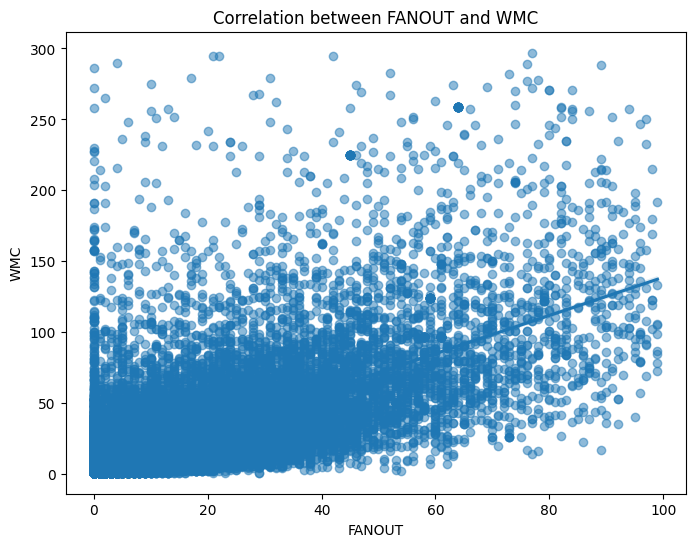

In [ ]:
plt.figure(figsize=(8, 6))
sns.regplot(x=filtered_df['FANOUT'], y=filtered_df['CC'], scatter_kws={'alpha': 0.5})
plt.xlabel("FANOUT")
plt.ylabel("WMC")
plt.title("Correlation between FANOUT and WMC")
plt.show()

Spearman correlation: 0.4579, p-value: 0.0000


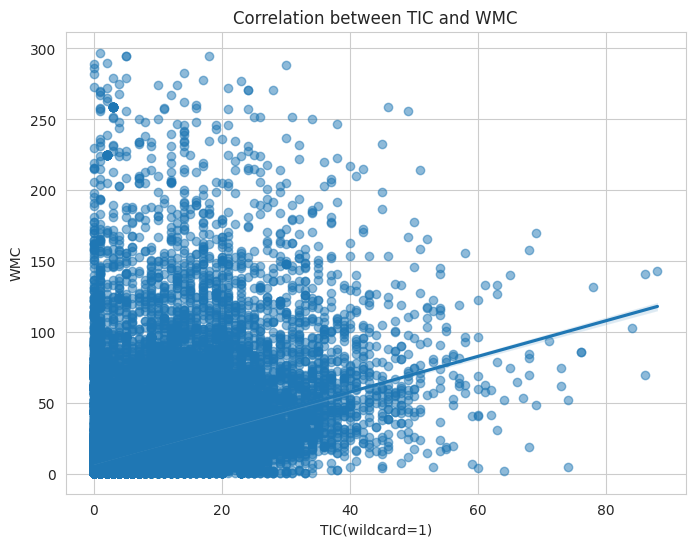

In [ ]:

plt.figure(figsize=(8, 6))
sns.regplot(x=filtered_df['Total_IMP'], y=filtered_df['CC'], scatter_kws={'alpha': 0.5})
plt.xlabel("TIC(wildcard=1)")
plt.ylabel("WMC")
plt.title("Correlation between TIC and WMC")
plt.show()

## Parameter analysis

Wildcard Cost: 1, Spearman correlation: 0.4692, p-value: 0.0000
Wildcard Cost: 2, Spearman correlation: 0.4612, p-value: 0.0000
Wildcard Cost: 3, Spearman correlation: 0.4584, p-value: 0.0000
Wildcard Cost: 4, Spearman correlation: 0.4555, p-value: 0.0000
Wildcard Cost: 5, Spearman correlation: 0.4525, p-value: 0.0000
Wildcard Cost: 6, Spearman correlation: 0.4496, p-value: 0.0000
Wildcard Cost: 7, Spearman correlation: 0.4467, p-value: 0.0000
Wildcard Cost: 8, Spearman correlation: 0.4439, p-value: 0.0000
Wildcard Cost: 9, Spearman correlation: 0.4414, p-value: 0.0000
Wildcard Cost: 10, Spearman correlation: 0.4392, p-value: 0.0000
Wildcard Cost: 11, Spearman correlation: 0.4370, p-value: 0.0000
Wildcard Cost: 12, Spearman correlation: 0.4350, p-value: 0.0000
Wildcard Cost: 13, Spearman correlation: 0.4334, p-value: 0.0000
Wildcard Cost: 14, Spearman correlation: 0.4318, p-value: 0.0000
Wildcard Cost: 15, Spearman correlation: 0.4304, p-value: 0.0000
Wildcard Cost: 16, Spearman correl

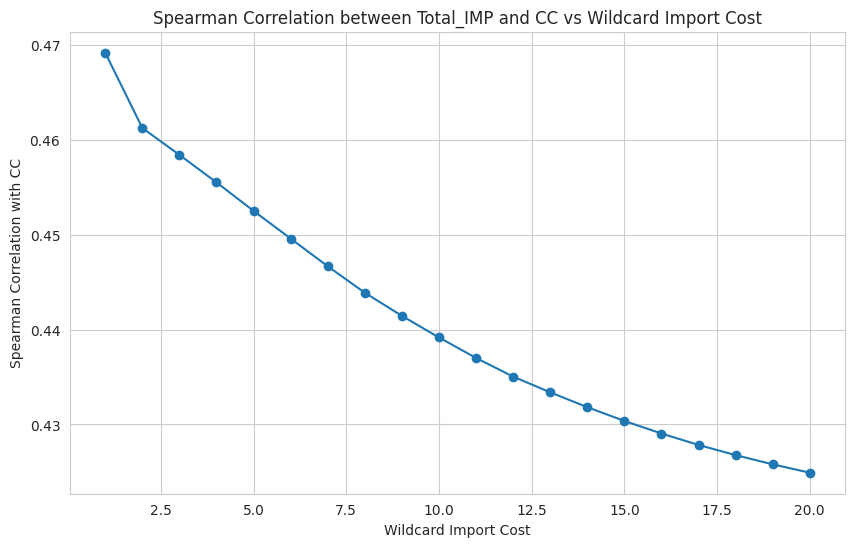

In [ ]:
cost_factors = np.arange(1, 21)
correlations = []
p_values = []

for cost in cost_factors:
    total_imp = merged_df['IMP_REGULAR'] + cost * merged_df['IMP_WILDCARD']
    corr, p_val = spearmanr(total_imp, merged_df['CC'])
    correlations.append(corr)
    p_values.append(p_val)
    print(f"Wildcard Cost: {cost}, Spearman correlation: {corr:.4f}, p-value: {p_val:.4f}")
plt.figure(figsize=(10, 6))
plt.plot(list(cost_factors), correlations, marker='o')
plt.title("Spearman Correlation between Total_IMP and CC vs Wildcard Import Cost")
plt.xlabel("Wildcard Import Cost")
plt.ylabel("Spearman Correlation with CC")
plt.grid(True)
plt.show()

Wildcard Cost: 0.0, Spearman correlation: 0.4045, p-value: 0.0000
Wildcard Cost: 0.1, Spearman correlation: 0.4309, p-value: 0.0000
Wildcard Cost: 0.2, Spearman correlation: 0.4493, p-value: 0.0000
Wildcard Cost: 0.30000000000000004, Spearman correlation: 0.4611, p-value: 0.0000
Wildcard Cost: 0.4, Spearman correlation: 0.4671, p-value: 0.0000
Wildcard Cost: 0.5, Spearman correlation: 0.4709, p-value: 0.0000
Wildcard Cost: 0.6000000000000001, Spearman correlation: 0.4729, p-value: 0.0000
Wildcard Cost: 0.7000000000000001, Spearman correlation: 0.4716, p-value: 0.0000
Wildcard Cost: 0.8, Spearman correlation: 0.4706, p-value: 0.0000
Wildcard Cost: 0.9, Spearman correlation: 0.4686, p-value: 0.0000
Wildcard Cost: 1.0, Spearman correlation: 0.4692, p-value: 0.0000
Wildcard Cost: 1.1, Spearman correlation: 0.4693, p-value: 0.0000
Wildcard Cost: 1.2000000000000002, Spearman correlation: 0.4675, p-value: 0.0000
Wildcard Cost: 1.3, Spearman correlation: 0.4660, p-value: 0.0000
Wildcard Cost: 

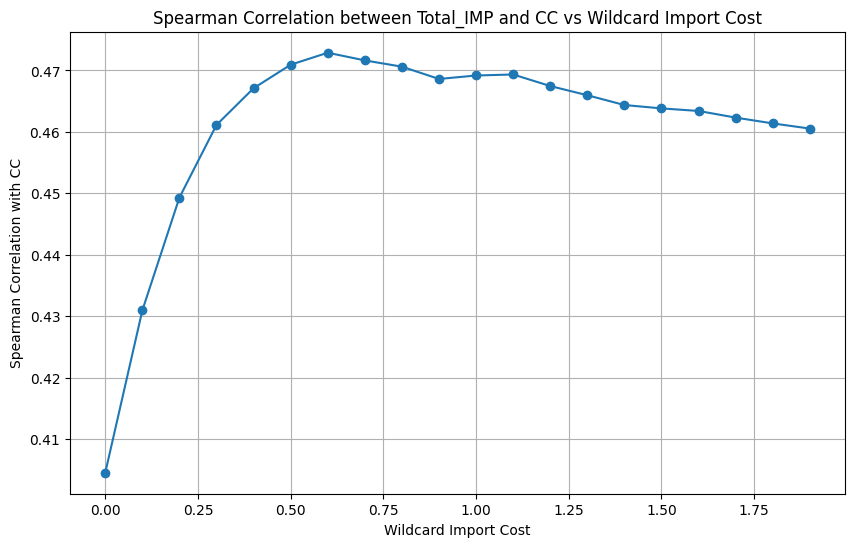

In [ ]:
cost_factors = np.arange(0, 2, 0.1)
correlations = []
p_values = []

for cost in cost_factors:
    total_imp = merged_df['IMP_REGULAR'] + cost * merged_df['IMP_WILDCARD']
    corr, p_val = spearmanr(total_imp, merged_df['CC'])
    correlations.append(corr)
    p_values.append(p_val)
    print(f"Wildcard Cost: {cost}, Spearman correlation: {corr:.4f}, p-value: {p_val:.4f}")
plt.figure(figsize=(10, 6))
plt.plot(list(cost_factors), correlations, marker='o')
plt.title("Spearman Correlation between Total_IMP and CC vs Wildcard Import Cost")
plt.xlabel("Wildcard Import Cost")
plt.ylabel("Spearman Correlation with CC")
plt.grid(True)
plt.show()

### Average classes per package

In [ ]:
av_df = pd.read_csv("average_classes.csv")
av_df

,average_classes
0,5.480605


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr, kendalltau

rho, p_rho = spearmanr(filtered_df['FANOUT'], filtered_df['CC'])
r, p_r = pearsonr(filtered_df['FANOUT'], filtered_df['CC'])
tau, p_tau = kendalltau(filtered_df['FANOUT'], filtered_df['CC'])
h, heh = kendalltau(filtered_df['Total_IMP'], filtered_df['CC'])

print(f"Spearman's ρ: {rho:.3f}, p = {p_rho:.3g}")
print(f"Pearson's r:  {r:.3f}, p = {p_r:.3g}")
print(f"Kendall's τ:  {tau:.3f}, p = {p_tau:.3g}")
print(f"Kendall's τ imports :  {h:.3f}, p = {heh:.3g}")

# 2. Scatter plot of FANOUT vs WMC (CC)
fig, ax = plt.subplots()
ax.scatter(filtered_df['FANOUT'], filtered_df['CC'])
ax.set_xlabel('Fan‑out (FANOUT)')
ax.set_ylabel('Weighted Method Complexity (WMC)')
ax.set_title('Scatter Plot of FANOUT vs WMC')

fig, ax = plt.subplots()
ax.scatter(filtered_df['IMP_REGULAR'], filtered_df['CC'])
ax.set_xlabel('IMP_REGULAR)')
ax.set_ylabel('Weighted Method Complexity (WMC)')
ax.set_title('Scatter Plot of IMP_REGULAR vs WMC')
plt.show()

828

## Is there correlation between fanout and weighted method cyclomatic complexity of a class?


In [ ]:
corr, p_value = spearmanr(filtered_df['FANOUT'], filtered_df['CC'])
print(f"Spearman correlation: {corr:.4f}, p-value: {p_value:.4f}")

## Is there correlation between TIC and weighted method cyclomatic complexity of a class?

In [ ]:
corr, p_value = spearmanr(filtered_df['Total_IMP'], filtered_df['CC'])
print(f"Spearman correlation: {corr:.4f}, p-value: {p_value:.4f}")


### 95% confidence interval

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from math import atanh, tanh, sqrt

rho, _ = corr, p_value

z = atanh(rho)
n = len(filtered_df)
se = 1 / sqrt(n - 3)

z_lower = z - 1.96 * se
z_upper = z + 1.96 * se

rho_lower = tanh(z_lower)
rho_upper = tanh(z_upper)

print(f"Spearman correlation: {rho:.4f}")
print(f"95% Confidence Interval: [{rho_lower:.4f}, {rho_upper:.4f}]")
